/var/folders/dl/8q6wl_5d3xg5j5ynz7vqlq_c0000gn/T/ipykernel_38715/4131432690.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_point["cpu_utilization"] = 0
/var/folders/dl/8q6wl_5d3xg5j5ynz7vqlq_c0000gn/T/ipykernel_38715/4131432690.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_point["cpu_utilization"] = frequency * 2


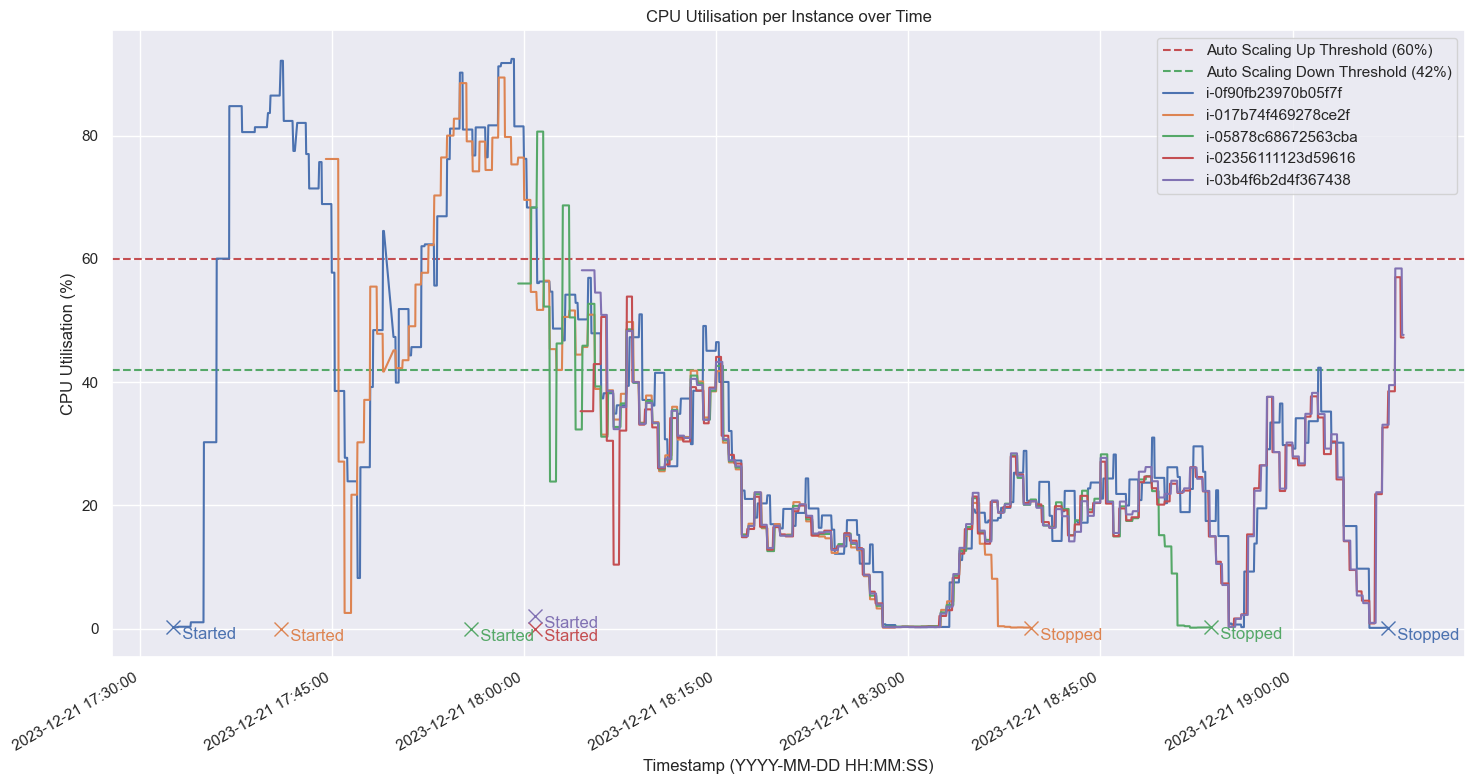

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Load the csv file
df = pd.read_csv("metrics.csv")

# Convert the timestamp column to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Configure the graph style
sns.set(style="darkgrid")

# Create a figure
plt.figure(figsize=(15, 8))

# Array to store the start timestamps of each instance
first_points_timestamps = []

# Dictionary to store colors for each instance
instance_colors = {} 

# Plot the line of 60% cpu utilisation (Threshold to trigger the creation of a new instance)
plt.axhline(y=60, color='r', linestyle='--', label="Auto Scaling Up Threshold (60%)")

# Plot the line of 42% cpu utilisation (Threshold to trigger the termination of an instance)
plt.axhline(y=42, color='g', linestyle='--', label="Auto Scaling Down Threshold (42%)")

# Draw the graph for each instance and add the first and last points
for instance_id in df["instance_id"].unique():
    # Get the data for the current instance
    instance_data = df[df["instance_id"] == instance_id]

    # Find the start timestamp of the current instance
    first_point = instance_data.iloc[0]
    if first_point["state"] == "pending":
        first_point["cpu_utilization"] = 0

    # Plot the cpu utilisation over time for the current instance
    (line,) = plt.plot(
        instance_data["timestamp"], instance_data["cpu_utilization"], label=instance_id
    )
    instance_colors[instance_id] = line.get_color()

    # Avoid superposing the first points of multiple instances
    if first_point["timestamp"] in first_points_timestamps:
        frequency = first_points_timestamps.count(first_point["timestamp"])
        first_point["cpu_utilization"] = frequency * 2

    # Add the first point to the array
    first_points_timestamps.append(first_point["timestamp"])

    # Find the end timestamp of the current instance
    last_point = instance_data.iloc[-1]
    if last_point["state"] == "terminated":
        plt.plot(
            last_point["timestamp"],
            last_point["cpu_utilization"],
            "x",
            color=instance_colors[instance_id],
            markersize=10,
        )  # Plot a cross at the last point of the curve
        plt.text(
            last_point["timestamp"],
            last_point["cpu_utilization"],
            "  Stopped",
            color=instance_colors[instance_id],
            verticalalignment="top",
        )  # Add a label "Stopped" near the cross

    # Plot a cross at the first point of the curve
    plt.plot(
        first_point["timestamp"],
        first_point["cpu_utilization"],
        "x",
        color=instance_colors[instance_id],
        markersize=10,
    )

    # Add a label "Started" near the cross
    plt.text(
        first_point["timestamp"],
        first_point["cpu_utilization"],
        "  Started",
        color=instance_colors[instance_id],
        verticalalignment="top",
    )


# Configure the graph
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Auto format the x axis
plt.xlabel("Timestamp (YYYY-MM-DD HH:MM:SS)")
plt.ylabel("CPU Utilisation (%)")
plt.title("CPU Utilisation per Instance over Time")
plt.legend(loc="upper right")
plt.tight_layout()

# Display the graph
plt.show()